# SAD - Synthetic Augmented Data Generator

This jupyter notebook allows a quick try out of our code.

## Table of Content

1) Preparation for Notebook

2) Creating Synthetic Data

3) Automatically augmenting real world data

4) Manually augmenting real world data


## Preparation for Notebook
Steps that are necessary before executing this notebook:
1) Create a virtual Python environment

For Linux
```bash
python3 -m venv venv4datagenerator
source venv4datagenerator/bin/activate
```
For Windows
```bash
python -m venv venv4datagenerator
venv4datagenerator\Scripts\activate.bat
```

2) Install dependencies
```
pip install -r requirements.txt
```

3) Launch Jupyter Notebook
```bash
jupyter notebook
```

## Chunks

The data generator picks the basic building blocks (chunks) from the folder `chunks` to dynamically create and annotate a ground plane. There are four different chunk types: `curve_left`, `curve_right`, `line` and `intersection`. For every chunk type there has to exist exactly one label and at least one image. If multiple images exist for one type they would be called variants of the chunk. The label contains the semantic information of the chunk. The image is the visual appearance of the road element. Every chunk type has a correspondent JSON file with its metadata. One important meta information is the ideal path that the car would take through the chunk.

This figure shows how the ground plane is modularily constructed from chunks.
<img width="50%" src="https://user-images.githubusercontent.com/88937076/138558644-222a3bcd-ea1d-46ec-918f-5033dd79b3ef.png"></img>

In our example the chunks represent the building blocks of a miniature track for a model car. By changing the chunk images, one can adapt the data generator to their own self-driving task. The chunk images need a consistent scale and size which has to be defined in the [config](CONFIG.md). Additionally the images have to be in the bird's-eye-view.

Run the following code block to see all available chunks in our demonstrator.


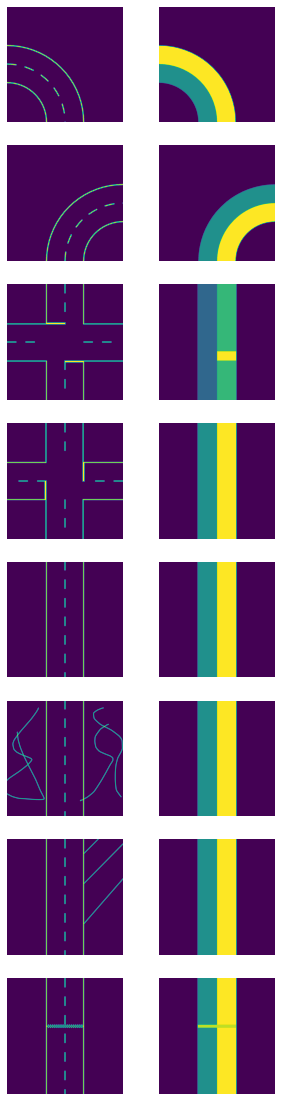

In [61]:
"""Plot all available chunks."""

annotations_list = glob.glob(".\chunks\*segment*.png")
len_list = len(annotations_list)

fig = plt.figure(figsize=(5, 20))

columns = 2
rows = len_list
for i in range(1, len_list+1):
    annotation_path = annotations_list[i-1]
    img = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    fig.add_subplot(rows, columns, 2*i)
    plt.axis('off')
    plt.imshow(img)

    img_path = annotation_path.replace("segment", "nice")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    fig.add_subplot(rows, columns, 2*i-1)
    plt.axis('off')
    
    try:
        plt.imshow(img)
    except:
        print("Following image was not found: " + str(img_path))
plt.show()


In [30]:

import matplotlib.pyplot as plt

In [1]:
import os
import time
import random
import argparse
import numpy as np
import cv2
import glob

from config import Config
import road
import render
from disturbances import *
import augment
from main import *
from startline import Startline
from manual_augment import ManualAugment

The JSON configuration file `config1.json` is used for most of the configuration.
The full reference is available in [CONFIG.md](CONFIG.md).



In [12]:
    config = Config("config1.json", debug=False)
    if config["seed"]:
        random.seed(config["seed"])
        np.random.seed(config["seed"])

    output_path_annotations = config["paths"]["annotations_output_path"]
    output_path_images = config["paths"]["images_output_path"]

    for name, split in config["splits"].items():
        os.makedirs(output_path_annotations.format(splitname=name),
                    exist_ok=True)
        os.makedirs(output_path_images.format(splitname=name), exist_ok=True)
        print("generating split", name)
        print("synthetic")
        print()
        idcs = list(range(split["size"]))
        if config["shuffle"]:
            random.shuffle(idcs)
        generate_synthetic(
            config,
            name,
            idcs[round(
                (1 - split["fraction_synthetic"]) *
                split["size"]):])

        print("augmented")
        generate_augmented(
            config,
            name,
            idcs[:round(
                split["fraction_augmented"] *
                split["size"])])

generating split train_split
synthetic

98.313 fps, {idx + 1}/{len(output_idcs)}
augmented
no annotated png images found under the path real_dataset/annotations/set_*
generating split validation_split
synthetic

77.956 fps, {idx + 1}/{len(output_idcs)}
augmented
no annotated png images found under the path real_dataset/annotations/set_*
generating split test_split
synthetic

86.043 fps, {idx + 1}/{len(output_idcs)}
augmented
no annotated png images found under the path real_dataset/annotations/set_*


In [11]:
    startline = Startline()
    index = 0

    startline_img, startline_mask = startline.draw_startline()

    annotations_list = glob.glob("./real_dataset/annotations/set_*/*.png")

    startline_img_, startline_mask_ = startline.create_overlay(startline_img)

    if len(annotations_list) == 0:
        print("no annotated images found under the path")

    for mask_path in annotations_list:
        img_path = mask_path.replace("annotations", "images")
        camera_img, camera_mask = startline.import_annotated_data(
                img_path, mask_path)
        bird_img, bird_mask = startline.get_birds_eye_view(
                camera_img, camera_mask)

        startline_img, startline_mask = (np.copy(startline_img_),
                                         np.copy(startline_mask_))
        key = 0
        while key != ord(" ") or ord("q"):

            startline_img, startline_mask = startline.transform_image(
                    startline_img, startline_mask, key)

            (bird_img_n, bird_mask_n,
             camera_img_n, camera_mask_n) = startline.merge_bird_overlay(
                    np.copy(startline_img), np.copy(startline_mask),
                    np.copy(bird_img), np.copy(bird_mask),
                    np.copy(camera_img), np.copy(camera_mask))
            key = startline.visualize_augmentation(bird_mask_n, bird_img_n,
                                                   camera_img_n, camera_mask_n,
                                                   index)

            if key == ord(" "):
                break
            if key == ord("q"):
                break
            if key == 27:
                exit()
        index += 1

no annotated images found under the path
